In [174]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from datetime import datetime
from collections import Counter

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15, 10]

pd.options.mode.chained_assignment = None

In [175]:
# Load CSV file into Dataframe
sf_data_2016 = pd.read_csv('../../../DataScience/Crime/SFPD_Crime_2016.csv')
sf_data_2015 = pd.read_csv('../../../DataScience/Crime/SFPD_Crime_2015.csv',)

# Data Wrangling

In [176]:
# Removing out of range coordiantes
# Y max has coordinates of 90 when max should be 38
outliers = (sf_data_2015['Y'] <= 38) & (sf_data_2015['Y'] >= 37)
sf_data_2015 = sf_data_2015[outliers]

In [177]:
def generate_heatmap(data_set, title):
    """
        This function will generate a heapmap of SF given a dataframe with X & Y coordinates.
    """
    # Assign SF DF series to sf_location
    location = data_set[['X', 'Y']]
        
    # Load SF city image
    sf_img = plt.imread('../Img/SF.png')

    # Create heatmap of SF City
    plt.hist2d(location['X'], location['Y'], bins=50, cmap='hot')
    plt.colorbar()
    plt.imshow(sf_img, extent=[location['X'].min(), location['X'].max(),
                               location['Y'].min(), location['Y'].max()], alpha=.3)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.show()

# SF Crime Rate 2016 Heatmap

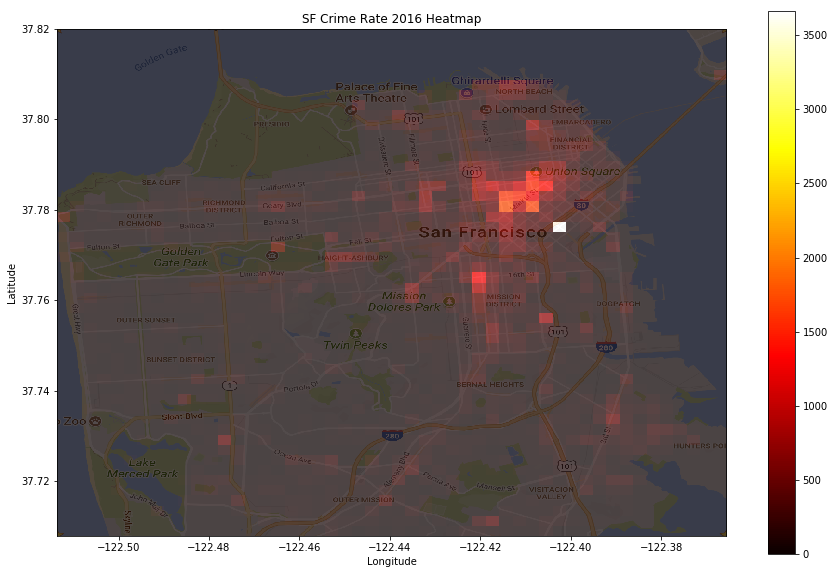

In [178]:
generate_heatmap(sf_data_2016, "SF Crime Rate 2016 Heatmap")

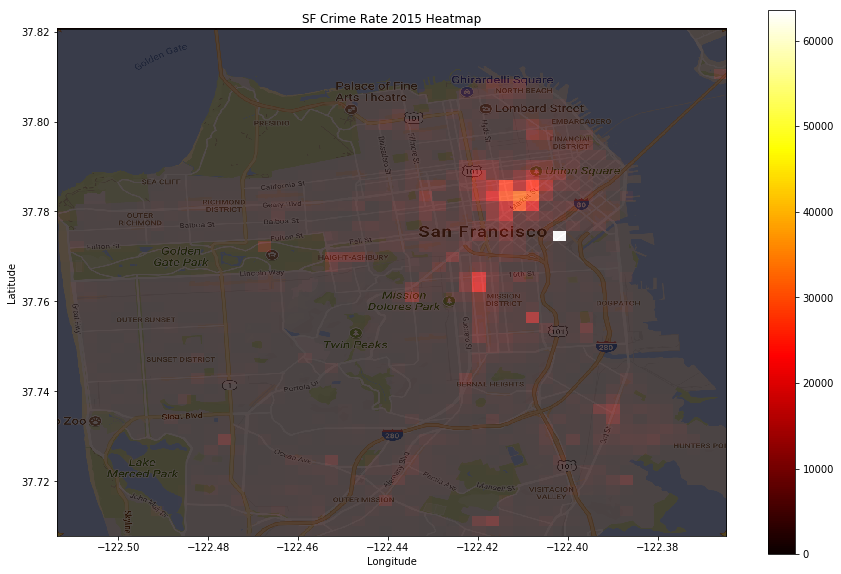

In [179]:
generate_heatmap(sf_data_2015, "SF Crime Rate 2015 Heatmap")

# SF Crime Rate 2016 Heatmap Split
* Split evenly to 9 region
* Zoom into each region


In [316]:
def grid_coordinates(data_set, size):
    """
        This function will generate a grid map of a given data set and total size X*Y = size
    """
    
    # Get Max and Min of the coordinates
    x_max, y_max = data_set.drop_duplicates().max()
    x_min, y_min = data_set.drop_duplicates().min()
    
    size = int(math.sqrt(size))

    # Find increment to split the map
    x_inc = (x_max - x_min) / size
    y_inc = (y_max - y_min) / size

    # Splitting map into 9 grids and store range in an array
    # 0 1 2
    # 3 4 5
    # 6 7 8

    # Empty grid
    grid = []

    # Assign max y coordinate to mover var
    y_move = y_max

    # Iterate through ranges y axis is the outside loop
    for y_loop in range(size):
        x_move = x_min
        y_move = y_move - y_inc 

        # Iterate through the x ranges
        for x_loop in range(size):
            x_move = x_move + x_inc
            grid.append([x_move, y_move])   
    
    # Return grid coordiantes and size of map
    return (grid, size)

In [323]:
grid, size = grid_coordinates(sf_data_2016[['X', 'Y']], 9)

In [324]:
for x in range(len(grid)):
    print(grid[x])

[-122.46428318462766, 37.782624296017538]
[-122.41492430499032, 37.782624296017538]
[-122.36556542535298, 37.782624296017538]
[-122.46428318462766, 37.745273099738071]
[-122.41492430499032, 37.745273099738071]
[-122.36556542535298, 37.745273099738071]
[-122.46428318462766, 37.707921903458605]
[-122.41492430499032, 37.707921903458605]
[-122.36556542535298, 37.707921903458605]


In [353]:

# Declare coordiantes
y_max = sf_data_2016['Y'].max()
y = grid[0][1]

# Iterate through row section of the grid
for row in range(size):
    
    # Assign the min range for X coordinates
    x_min = sf_data_2016['X'].min()
    
    # If not first iteration, adjust the y coordinates
    if(row != 0):
        try:
            y_max = grid[(row * size) - 1][1]
            y     = grid[((row + 1) * size) - 1][1]
        except IndexError:
            y     = grid[-1][1]
    
    # Iterate through column section of the gride
    for col in range(size):
        
        # Set X position
        x = grid[col][0]
        
        # Boolean operation to check if any points lay inside the gride
        test = ((sf_data_2016['X'] > x_min) &
                (sf_data_2016['X'] < x) &
                (sf_data_2016['Y'] < y_max) &
                (sf_data_2016['Y'] > y)      
        )

        # Shift our limit over to the next grid
        x_min = x
        
        # Assign booleam operation and create a new dataframe for the each grid
        test_df = sf_data_2016[test]
        print('{} : {}'.format(col, len(test_df)))

0 : 846
1 : 20368
2 : 28485
0 : 8585
1 : 35525
2 : 28776
0 : 5443
1 : 11293
2 : 11051


# Crime Rate Per Year

### Mean / Standard Error

In [184]:
def mean_std_err(dataset):
    """
        This function will calculate the mean, std dev, and std error
        Return: std_err
    """
    
    total_crime_count = 0

    # Iterate throught Counter to get total crime
    for x in dataset:
        total_crime_count += sf_day_count[x]

    # Mean of crimes
    crime_count_mean = math.ceil(total_crime_count / len(dataset))

    sum_of_sqaure = []

    # Devation from the mean and then squared
    for x in dataset:
        sum_of_sqaure.append((crime_count_mean - dataset[x])**2)

    # Sum squared and divide by sample size - 1
    sum_minus_sample_size = sum(sum_of_sqaure)/(len(dataset) - 1)
    
    # Standard devation : sqrt of sum minus sample size - 1
    std_dev = math.sqrt(sum_minus_sample_size)
    
    # Standard error: std_dev / sqrt(n)
    std_err = std_dev / math.sqrt(len(dataset))
    
    return (std_err, crime_count_mean)
    


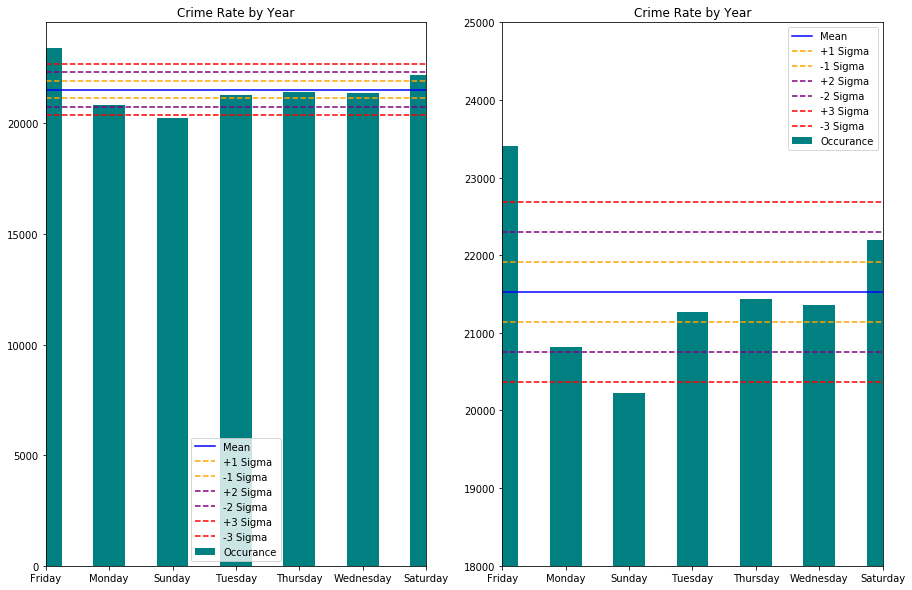

In [185]:
## This section helps us determine which days of the week is crimee occurs the most

# Assign DayOfWeek series to a Counter
sf_day_count = Counter(sf_data_2016['DayOfWeek'])

# Call mean_std_err function
std_err, mean = mean_std_err(sf_day_count)

# Broadcast new columns
df = pd.DataFrame.from_dict(sf_day_count, orient='index')
df.columns = ['Occurance']
df['Mean'] = mean
df['Std Error'] = std_err
df['+1 Sigma'] = mean + std_err
df['-1 Sigma'] = mean - std_err
df['+2 Sigma'] = mean + (std_err * 2)
df['-2 Sigma'] = mean - (std_err * 2)
df['+3 Sigma'] = mean + (std_err * 3)
df['-3 Sigma'] = mean - (std_err * 3)

# Plot frequency in terms of days
ax = plt.subplot(1,2,1)
df['Occurance'].plot.bar(title='Crime Rate by Year', color="teal", ax=ax)
df['Mean'].plot(kind='line', color='blue', ax=ax)
df[['+1 Sigma', '-1 Sigma']].plot(kind='line', linestyle='--', color='orange', ax=ax)
df[['+2 Sigma', '-2 Sigma']].plot(kind='line', linestyle='--', color='purple', ax=ax)
df[['+3 Sigma', '-3 Sigma']].plot(kind='line', linestyle='--', color='red', ax=ax)
plt.legend()

# Plot zoomed in view
ax1 = plt.subplot(1,2,2)
df['Occurance'].plot.bar(title='Crime Rate by Year', color="teal", ax=ax1, ylim=(18000, 25000))
df['Mean'].plot(kind='line', color='blue', ax=ax1)
df[['+1 Sigma', '-1 Sigma']].plot(kind='line', linestyle='--', color='orange', ax=ax1)
df[['+2 Sigma', '-2 Sigma']].plot(kind='line', linestyle='--', color='purple', ax=ax1)
df[['+3 Sigma', '-3 Sigma']].plot(kind='line', linestyle='--', color='red', ax=ax1)
plt.legend()


# Hypothesis Testing for Crime Rate
Null Hypothesis:  μ = 21528 rate per year <br/>
Alternative         : μ ≠ 21528 rate per year

# Crime Rate by the Hour (Year 2016)

In [186]:
## This section helps us determine the frequency of crime rate by the hour

# Assign SF DF date series into a list
sf_date = list(sf_data_2016['Date'])

# Formate date str to dt object
for date in sf_date:
    date_dt = datetime.strptime(date, '%m/%d/%Y %H:%M:%S %p')
    
# Assign SF DF time series into a list
sf_time = list(sf_data_2016['Time'])
sf_time_list = []

# Formate time list and append to sf_time_list
for time in sf_time:
    time_dt = datetime.strptime(time, '%H:%M')
    sf_time_list.append(time_dt.time())

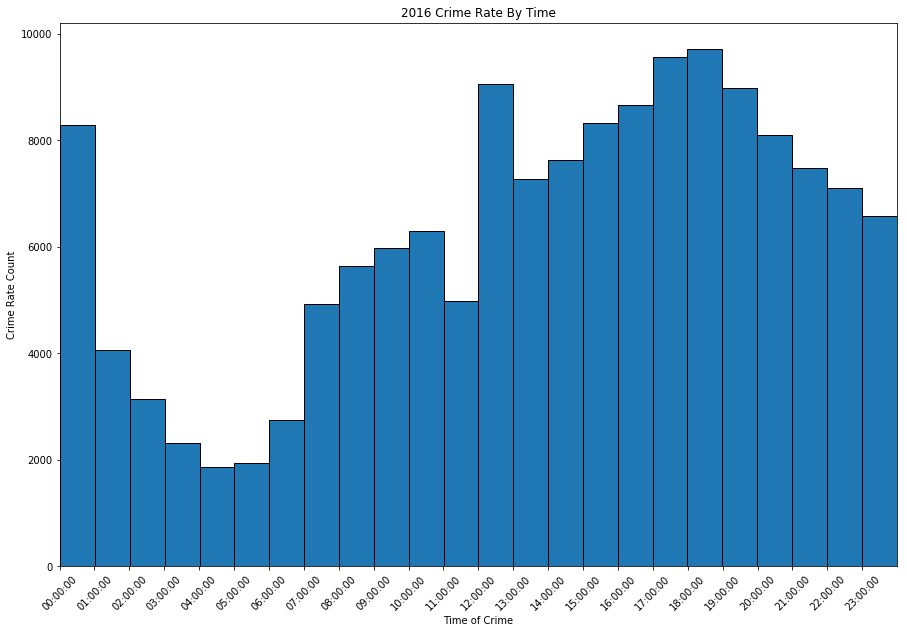

In [187]:
# Create histogram of Crime Rate
y, x, sf_hist = plt.hist(sf_time_list, bins=24, edgecolor="black")

hour_by_sec = []
for hour in range(24):
    hour_by_sec.append(hour * (60*60))

plt.title("2016 Crime Rate By Time")
plt.xlabel("Time of Crime")
plt.xlim([0, max(sf_time_list)])
plt.xticks(hour_by_sec, rotation = 45)
plt.ylabel("Crime Rate Count")
plt.show()

# Crime Rate by the Day (Year 2016)

In [188]:
def boolean_filter_col(dataset, target_name, col_name):
    """
        This function function uses boolean operations to extract the data you're trying to target
        Param: dataset     : DataFrame
               target_name : Str target
               col_name    : Dataframe series
        Return: Dataframe
    """
    target_filter = (dataset.loc[:, col_name] == target_name)
    temp_df = dataset[target_filter]
    
    return temp_df

In [189]:
def day_hist(dataset, list_name, col_name, title = "Crime"):
    
    for count, day in enumerate(list_name):
        temp_df = boolean_filter_col(dataset, day, col_name)
    
        #Assign SF DF time series into a list
        temp_time = list(temp_df['Time'])
        time_list = []

        # Formate time list and append to sf_time_list
        for x in temp_time:
            time_dt = datetime.strptime(x, '%H:%M')
            time_list.append(time_dt.time())

        plt.subplot(4,2,count+1)
        
        # Create histogram of Crime Rate
        plt.hist(time_list, bins=24, edgecolor='black', color="orange")

        hour_by_sec = []
        
        for hour in range(24):
            hour_by_sec.append(hour * (60*60))

        plt.title("{} Rate on {}".format(title, day))
        plt.xlabel("Time of Crime")
        plt.xlim([0, 86400])
        plt.xticks(hour_by_sec, rotation = 90)
        plt.ylabel("Crime Rate Count")
        plt.tight_layout()


    plt.show()   

In [190]:
# Create Dataframe with columns
sf_date = sf_data_2016[['DayOfWeek', 'Time']]

# Create list of names of days in week
days_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a catergorical list from day_list
sf_date['cat_days'] = pd.Categorical(sf_date['DayOfWeek'], categories=days_list, ordered=True)

# Sort your catergorical into a new data frame
temp_df = sf_date.sort_values('cat_days')

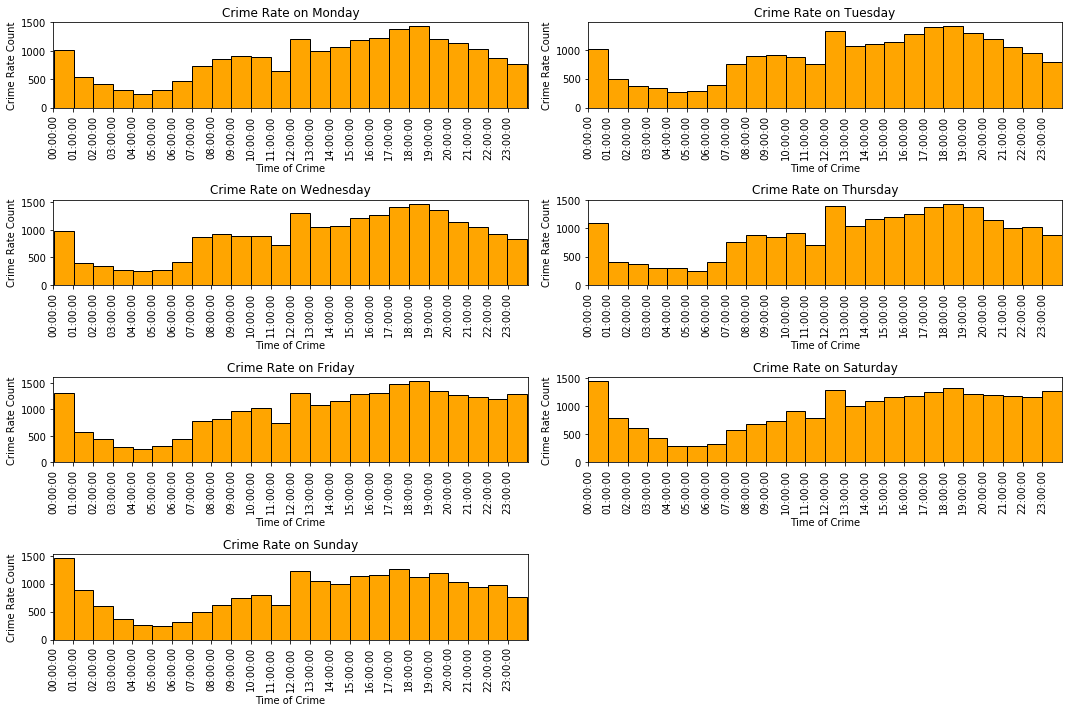

In [191]:
day_hist(temp_df, days_list, 'DayOfWeek')


# Frequency of Crime Types (Year 2016)

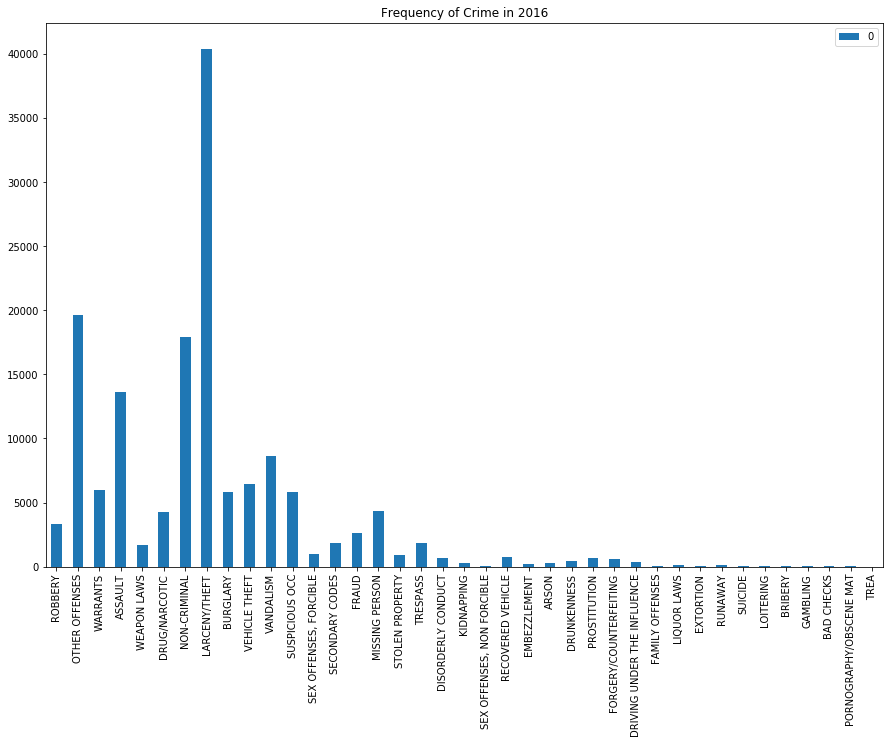

In [192]:
# Create counter dict using Category series
sf_crime_count = Counter(sf_data_2016['Category'])

# Plot out the types and frequency of crimes
df = pd.DataFrame.from_dict(sf_crime_count, orient='index')
df.plot(kind='bar', title='Frequency of Crime in 2016')

In [193]:
sf_crime_count.most_common(10)

[('LARCENY/THEFT', 40419),
 ('OTHER OFFENSES', 19648),
 ('NON-CRIMINAL', 17884),
 ('ASSAULT', 13592),
 ('VANDALISM', 8593),
 ('VEHICLE THEFT', 6420),
 ('WARRANTS', 5953),
 ('BURGLARY', 5806),
 ('SUSPICIOUS OCC', 5792),
 ('MISSING PERSON', 4342)]

# Examine Crimes with Respect to Time & Day
1. LARCENY/THEFT
2. ASSAULT
3. VANDALISM
4. VEHICLE THEFT
5. BURGLARY

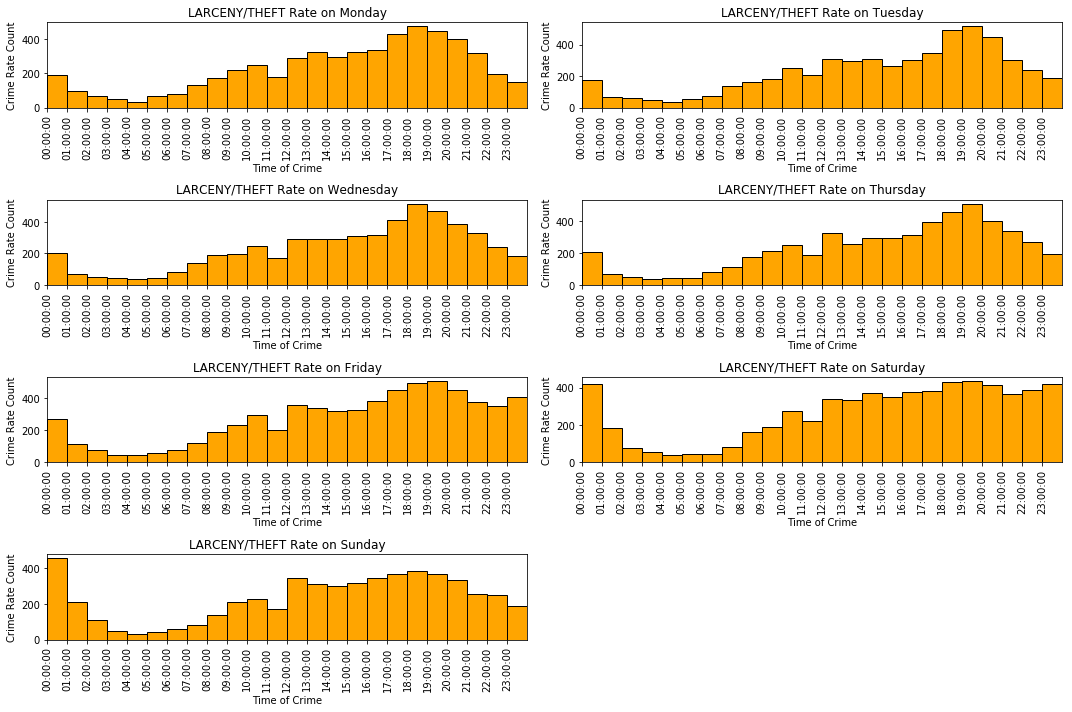

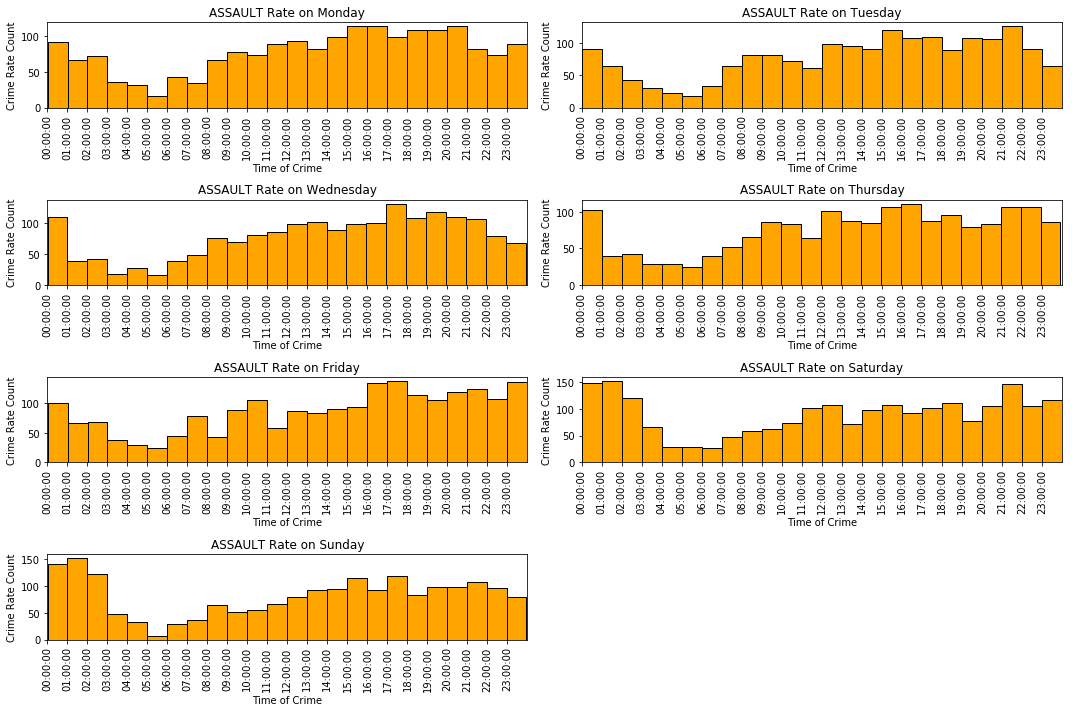

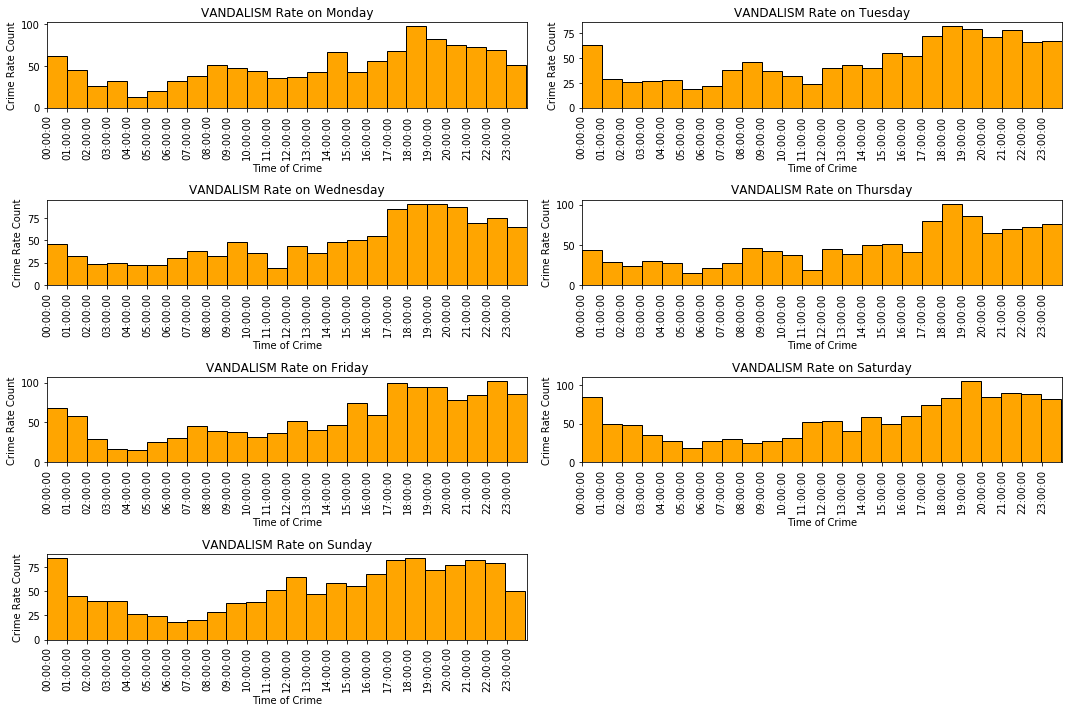

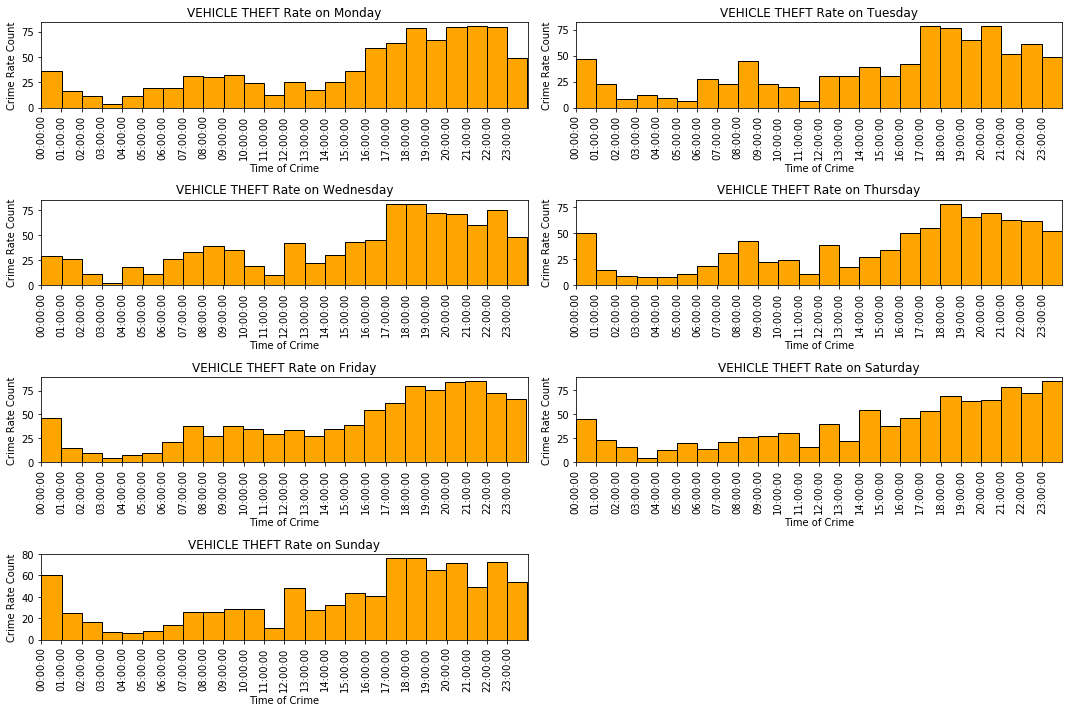

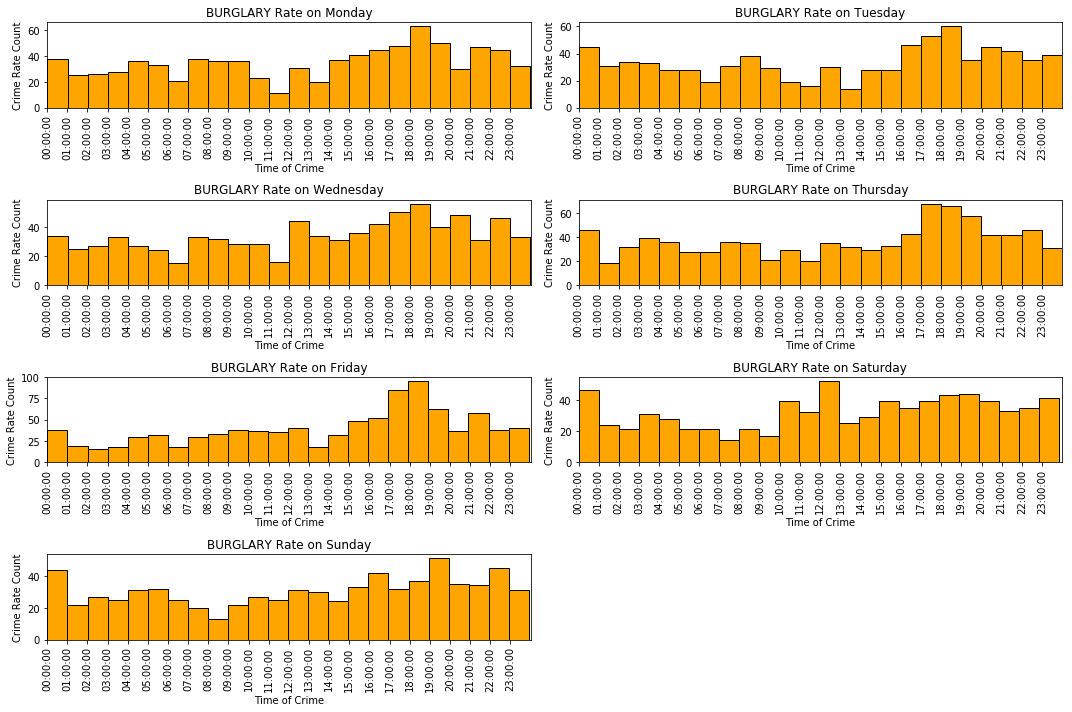

In [194]:
# Create target list
crime_list = ['LARCENY/THEFT', 'ASSAULT', 'VANDALISM', 'VEHICLE THEFT', 'BURGLARY']

# Create a df with a crime catergory column
crime_df = sf_data_2016[['DayOfWeek', 'Time', 'Category']]

# Create a catergorical list from day_list
crime_df['cat_days'] = pd.Categorical(crime_df['DayOfWeek'], categories=days_list, ordered=True)

# Sort your catergorical into a new data frame
crime_df = crime_df.sort_values('cat_days')

# day_hist(temp_df, crime_list, 'Category')

for x in range(len(crime_list)):
    temp_df = boolean_filter_col(crime_df, crime_list[x], 'Category')
    day_hist(temp_df, days_list, 'DayOfWeek', crime_list[x])

In [195]:
def convert_time(time):
    """
        This function converts a string obj to a datetime object.
        return: datetime
    """
    
    time = datetime.strptime(time, '%H:%M:%S')
    
    return time.time()

In [196]:
def timeframe_index(start_index, time_period):
    """
        This function will find the range for secitions of the day.
        return: cut off index
    """
    
    for count, time in enumerate(df['Time'][start_index:]):
        if(time >= time_period):
            return count

In [197]:
## Create heatmap from 12am-6am, 6am-12pm, 12pm-6pm, 6pm-12am

# Create dataframe
df = pd.DataFrame()

# Create Time & CrimeType columns
df['Time']     = sf_time_list
df['Category'] = sf_data_2016['Category']
df['Location'] = sf_data_2016['Location']
df[['X', 'Y']] = sf_data_2016[['X', 'Y']]

# Sort by acending time
df = df.sort_values('Time')

# Convernt strings to datetime objects
morning   =  convert_time('6:00:00')
afternoon =  convert_time('12:00:00')
evening   =  convert_time('18:00:00')
midnight  =  convert_time('23:59:59')

# Find the range to use for spliting up dataframe
midnight_morning   = timeframe_index(0, morning)
morning_afternoon  = timeframe_index(midnight_morning, afternoon)
afternoon_evening  = timeframe_index(morning_afternoon, evening)
evening_midnight   = len(df)

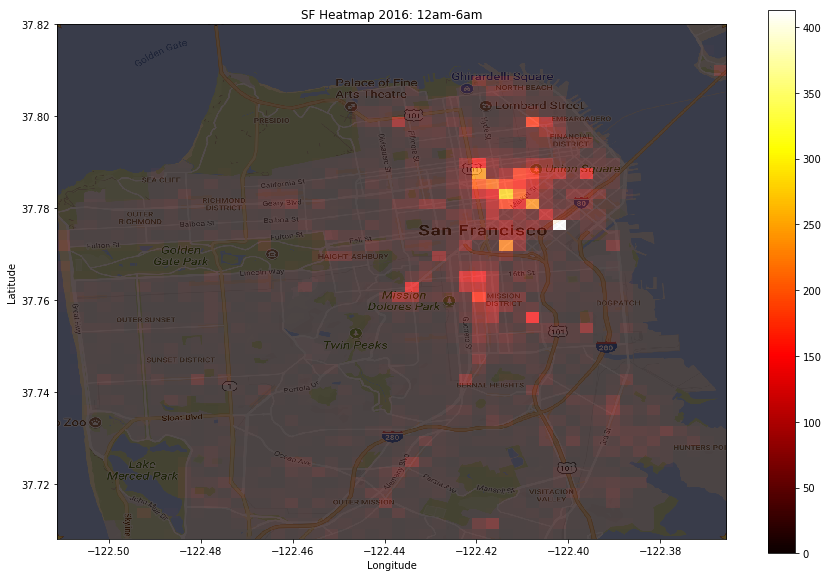

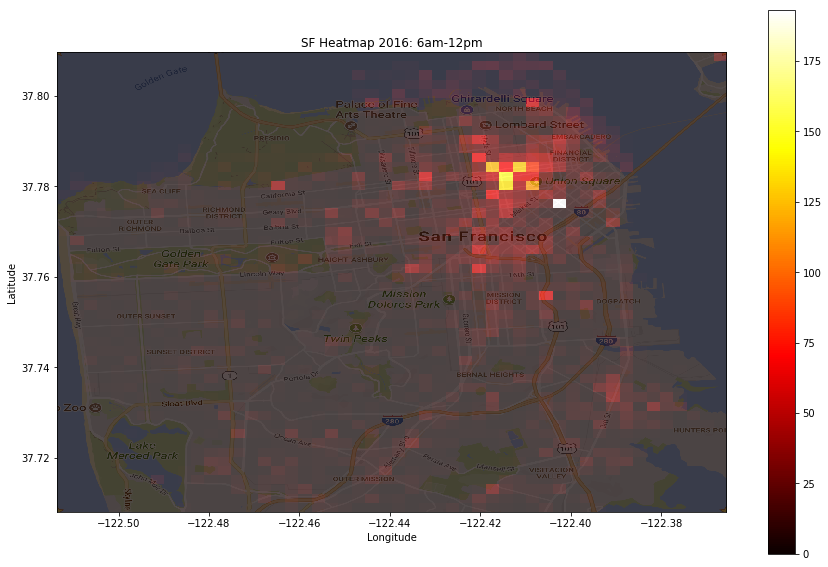

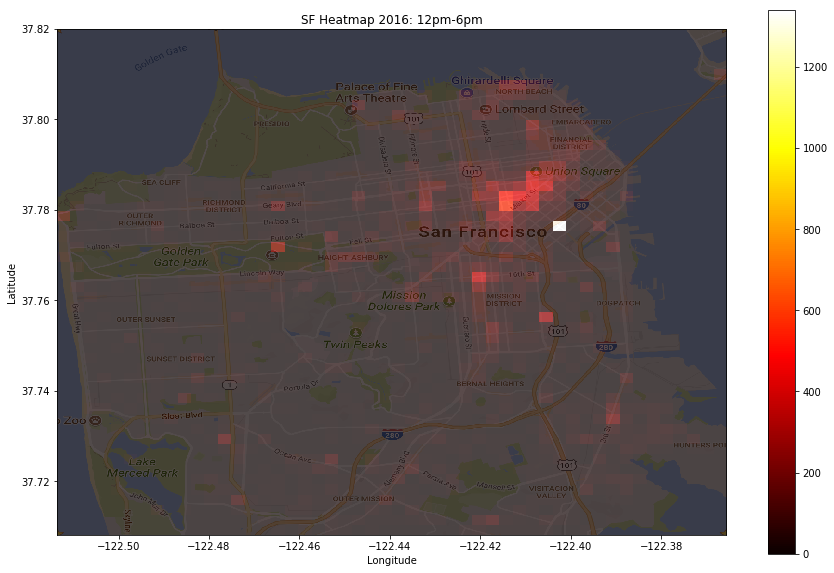

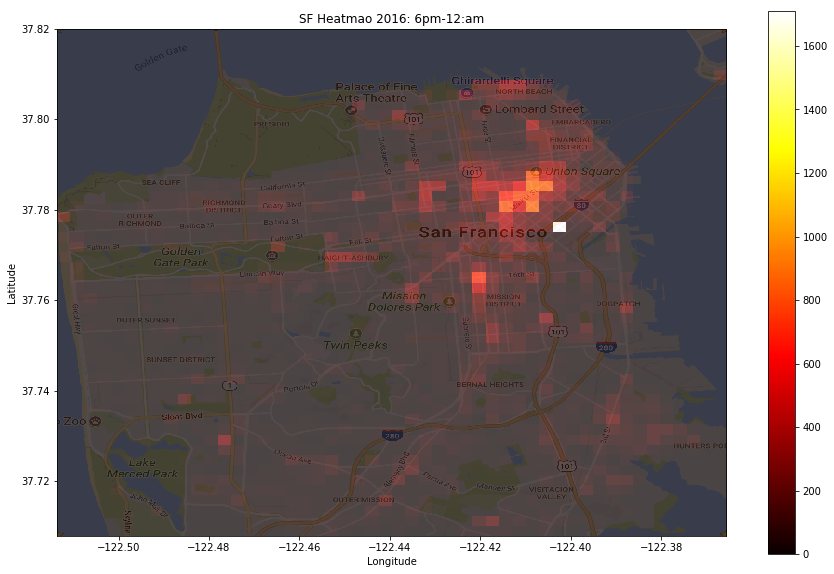

In [198]:
generate_heatmap(df[0                 : midnight_morning] , "SF Heatmap 2016: 12am-6am")
generate_heatmap(df[midnight_morning  : morning_afternoon], "SF Heatmap 2016: 6am-12pm")
generate_heatmap(df[morning_afternoon : afternoon_evening], "SF Heatmap 2016: 12pm-6pm")
generate_heatmap(df[afternoon_evening : evening_midnight] , "SF Heatmao 2016: 6pm-12:am")

In [199]:
## Find out if crime is increasing throughout the year

# create new dataframe
df = pd.DataFrame()

# assign date column datatime objects
df['Date'] = pd.to_datetime(sf_data_2016['Date'])

# sort by date
df = df.sort_values('Date')

In [200]:
count = 0
target = 1
month_list = []

for x in df['Date']:
    if(x.month == target):
        count += 1
    elif(target == 13):
        break
    else:
        month_list.append(count)
        count = 0
        target += 1

month_list.append(count)

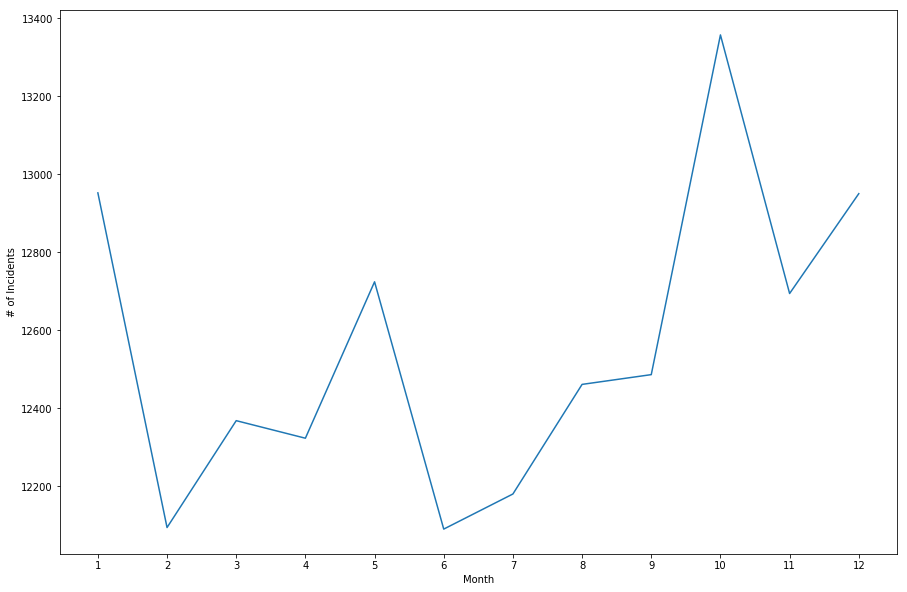

In [201]:
plt.plot(month_list)
plt.xticks(range(12), range(1,13))
plt.xlabel('Month')
plt.ylabel('# of Incidents')
plt.show()